In [3]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add


In [4]:
BASE_DIR = '/kaggle/input/flickr8k-dataset'
WORKING_DIR = '/kaggle/working'

**Extract Image Features**

In [5]:
#load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs,outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
#extract features from image
from tqdm import tqdm
features = {}
directory = os.path.join(BASE_DIR,'Images')

for img_name in tqdm(os.listdir(directory)):
    #load the image from file
    img_path = directory + '/'+ img_name
    image = load_img(img_path, target_size =(224, 224))
    #convert image pixels to numpy array
    image = img_to_array(image)
    #reshape data for model
    image = image.reshape((1, image.shape[0],image.shape[1], image.shape[2]))
    #preprocess image for vgg
    image = preprocess_input(image)
    #extract features
    feature = model.predict(image, verbose=0)
    #get image ID
    image_id = img_name.split('.')[0]
    #store feature
    features[image_id] = feature
    

  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1731513063.697432      78 service.cc:145] XLA service 0x7ef428005190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731513063.697484      78 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731513063.697488      78 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731513066.276345      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [10:54<00:00, 12.37it/s]


In [10]:
#store features in pickle
pickle.dump(features,open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))

In [11]:
#load features from pickle
with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f:
    features = pickle.load(f)

## Load the Captions data

In [12]:
with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
    next(f)
    captions_doc = f.read()

In [16]:
#create mapping of the image to captions
mapping = {}
#process lines 
for line in tqdm(captions_doc.split('\n')):
    #split the line by comma(,)
    tokens = line.split(',')
    if len(line)< 2:
        continue
    image_id, caption = tokens[0],tokens[1:]
    #remove extension from image ID
    image_id = image_id.split('.')[0]
    #convert caption list to string
    caption = " ".join(caption)
    #create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    #store the caption
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 376779.18it/s]


In [17]:
len(mapping)

8091

## Preprocess Text Data

In [21]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        #take one caption at a time
           caption = captions[i]
           #preprocessing steps
           #convert to lowercase
           caption = caption.lower()
           #delete digits, special chars,etc..
           caption = caption.replace('[A-Za-z]', '')
           #delete additional space 
           caption = caption.replace('\s+',' ')
           #add start and tags to the caption
           caption=  '<start>'+" ".join([word for word in caption.split() if len(word)>1])+'<end>'
           captions[i] = caption

In [22]:
#before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [23]:
#preprocess the text
clean(mapping)

In [24]:
#after preprocess of text
mapping['1000268201_693b08cb0e']

['<start>child in pink dress is climbing up set of stairs in an entry way<end>',
 '<start>girl going into wooden building<end>',
 '<start>little girl climbing into wooden playhouse<end>',
 '<start>little girl climbing the stairs to her playhouse<end>',
 '<start>little girl in pink dress going into wooden cabin<end>']

In [26]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [27]:
len(all_captions)

40455

In [28]:
all_captions[:10]

['<start>child in pink dress is climbing up set of stairs in an entry way<end>',
 '<start>girl going into wooden building<end>',
 '<start>little girl climbing into wooden playhouse<end>',
 '<start>little girl climbing the stairs to her playhouse<end>',
 '<start>little girl in pink dress going into wooden cabin<end>',
 '<start>black dog and spotted dog are fighting<end>',
 '<start>black dog and tri-colored dog playing with each other on the road<end>',
 '<start>black dog and white dog with brown spots are staring at each other in the street<end>',
 '<start>two dogs of different breeds looking at each other on the road<end>',
 '<start>two dogs on pavement moving toward each other<end>']

In [30]:
#tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [31]:
vocab_size

8483

In [32]:
#get maximum length of the captons available
max_length = max(len(caption.split())for caption in all_captions)
max_length

33

## Train Test Split

In [78]:
image_ids = list(mapping.keys())
split = int(len(image_ids) + 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
#<start>girl going into wooden building<end>
#       X                    y
#<start>                    girl
#<start> girl               going
#<start> girl going         into
#...........
#<start> girl going into wooden building <end>

In [79]:
#create data generator to get data in batch(avoids session crash)
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            #process each caption
            for caption in captions:
                #encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                #split the sequence into X, y,pairs
                for i in range(1,len(seq)):
                    #split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    #pad input sequence 
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    # encode output sequence 
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]

                    #store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1,X2,y = np.array(X1),np.array(X2), np.array(y)
                yield [X1,X2],y
                X1 ,X2 , y = list(),list(), list()
                n = 0
                    
                

## Model Creation

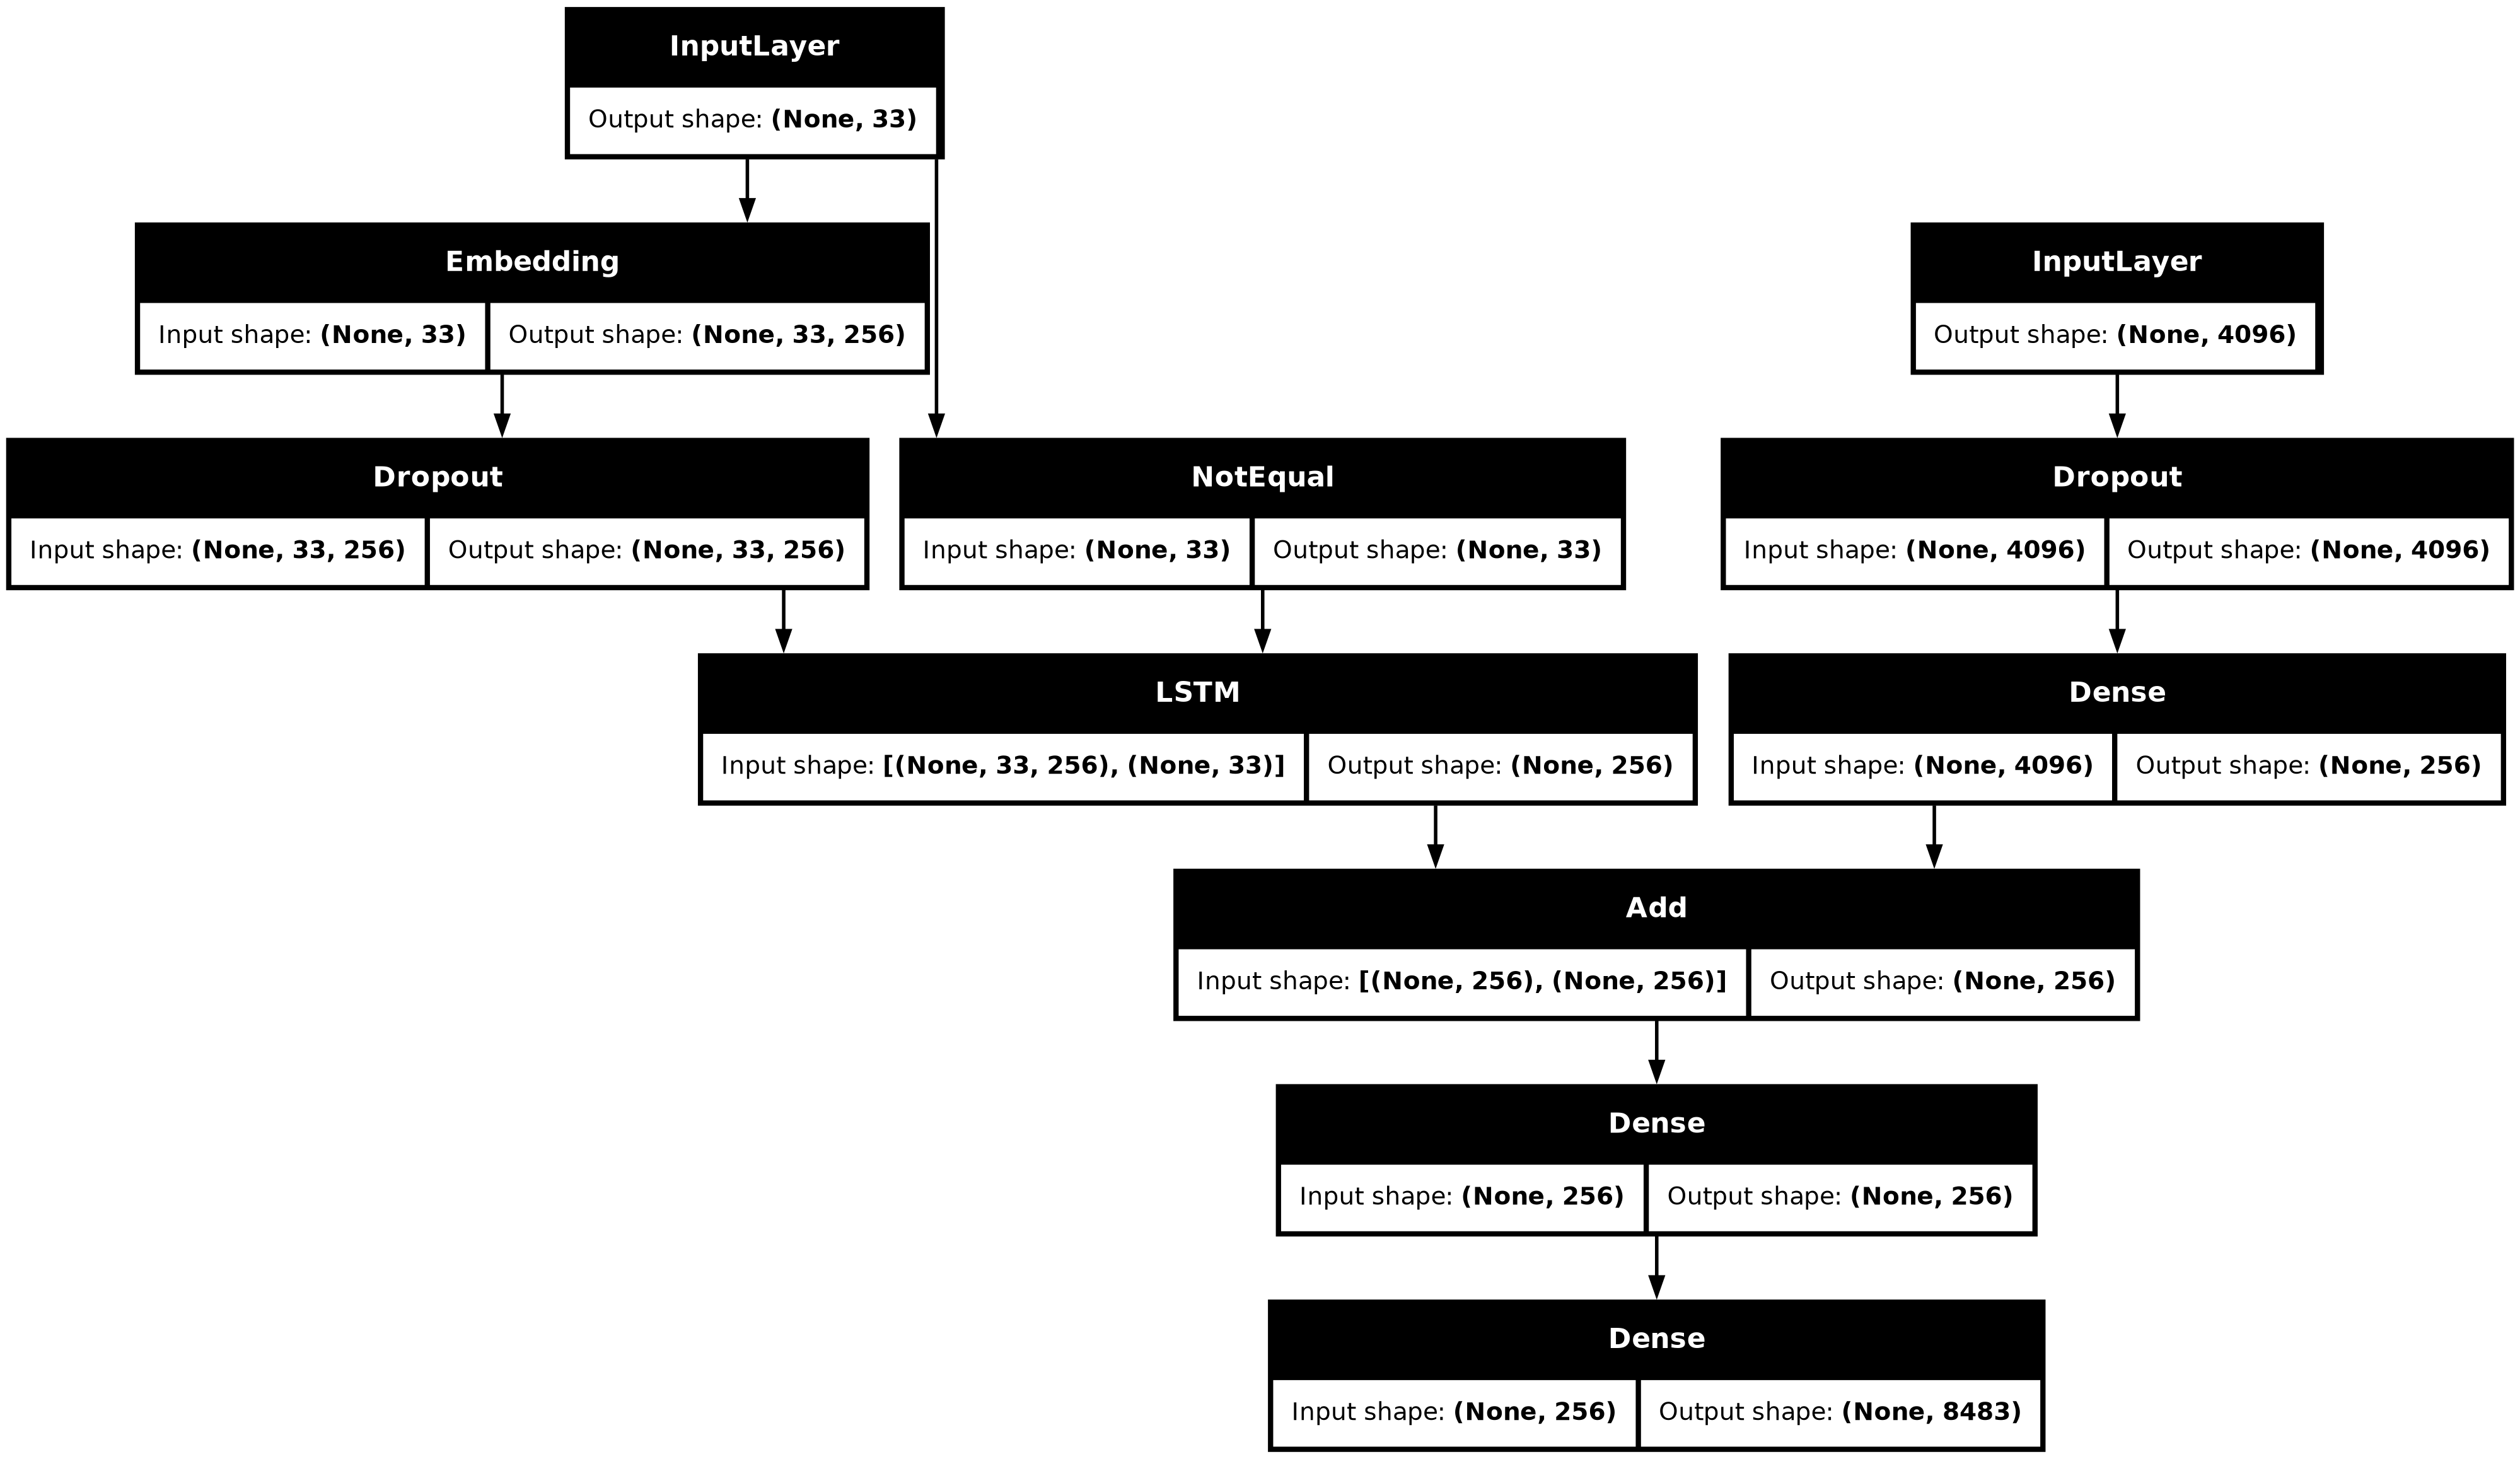

In [80]:
#encoder model
#image features layers 

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation ='relu')(fe1)
#sequence features layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256 , mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#decoder model
decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss ='categorical_crosssentropy', optimizer= 'adam')

#plot the model
plot_model(model, show_shapes= True)

In [82]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 33, 256)   │  2,171,648 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 4096)      │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 33, 256)   │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 33)        │          0 │ input_layer_8[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 256)       │    525,312 │ dropout_7[0][0],  │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256)       │          0 │ dense_8[0][0],    │
│                     │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │     65,792 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 8483)      │  2,180,131 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,991,715 (22.86 MB)

 Trainable params: 5,991,715 (22.86 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
def data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        for i in range(0, len(train), batch_size):
            x1 =33   # Your logic for the first input
            x2 = 4096  # Your logic for the second input
            y =     # Your logic for the target output
            yield (x_batch_1, x_batch_2), y_batch  # Yield a tuple of inputs and targets

SyntaxError: invalid syntax (1175233434.py, line 6)

In [71]:
#save the model
model.save(WORKING_DIR+'/best_model.h5')